In [3]:
#!pip install scikit-learn pandas numpy torch tqdm matplotlib pyarrow

In [19]:
from plot_trajectory import plot_paths
import training
import json
import torch
from torch.utils.data import DataLoader
from dataloader import load_val
import joblib
import os
import matplotlib.pyplot as plt
from model_autoregressive import Seq2SeqLSTM
import numpy as np
from tqdm import tqdm

In [20]:
device = training.determine_device()
print("Using device:", device)

Using device: cpu


In [ ]:
base_path = "results_filtered/results_filtered"
#these jsons files contain the results of different models on the validation set
model_files = [
    "deeper_autoreg_lstm_2_results-2025-11-27T20:29:49.json",
    "deeper_autoreg_lstm_results-2025-11-28T00:57:47.json",
    "deeper_lstm_2_results-2025-11-27T12:05:36.json",
    "deeper_lstm_results-2025-11-27T13:04:46.json",
    "deeper_transformer_2_results-2025-11-27T10:28:16.json",
    "deeper_transformer_results-2025-11-27T11:08:35.json",
    "medium_autoreg_lstm_results-2025-11-27T17:10:27.json",
    "medium_lstm_results-2025-11-27T12:00:40.json",
    "medium_transformer_results-2025-11-27T10:21:55.json",
    "mini_autoreg_lstm_results-2025-11-27T16:42:51.json",
    "mini_lstm_results-2025-11-27T11:44:43.json",
    "mini_transformer_results-2025-11-27T09:44:36.json",
    "small_autoreg_lstm_results-2025-11-27T17:06:56.json",
    "small_lstm_results-2025-11-27T11:50:55.json",
    "small_transformer_results-2025-11-27T10:12:31.json"
]

'\n    "deeper_autoreg_lstm_2_results-2025-11-27T20:29:49.json",\n    "deeper_autoreg_lstm_results-2025-11-28T00:57:47.json",\n    "deeper_lstm_2_results-2025-11-27T12:05:36.json",\n    "deeper_lstm_results-2025-11-27T13:04:46.json",\n    "deeper_transformer_2_results-2025-11-27T10:28:16.json",\n    "deeper_transformer_results-2025-11-27T11:08:35.json",\n    "medium_autoreg_lstm_results-2025-11-27T17:10:27.json",\n    "medium_lstm_results-2025-11-27T12:00:40.json",\n    "medium_transformer_results-2025-11-27T10:21:55.json",\n    "mini_autoreg_lstm_results-2025-11-27T16:42:51.json",\n    "mini_lstm_results-2025-11-27T11:44:43.json",\n    "mini_transformer_results-2025-11-27T09:44:36.json",\n    "small_autoreg_lstm_results-2025-11-27T17:06:56.json",\n    "small_lstm_results-2025-11-27T11:50:55.json",\n    "small_transformer_results-2025-11-27T10:12:31.json"\n]'

In [22]:
#find out which (filtered) model performs the best based on MSE on val set
best_model = None
best_val_mse = float('inf')
best_model_data = None

print("Best validation MSE per model:\n")
for f in model_files:
    full_path = os.path.join(base_path, f)

    with open(full_path, "r") as fp:
        data = json.load(fp)
    model_name = data["config"]["name"]
    val_mse = data["history"]["val_mse"]
    model_best_mse = min(val_mse)
    print(f"{model_name:30s}  best MSE = {model_best_mse:.6f}")
    if model_best_mse < best_val_mse:
        best_val_mse = model_best_mse
        best_model = model_name
        best_model_data = data
print("\nOverall best model:")
print(f"{best_model} with best validation MSE = {best_val_mse:.6f}")

Best validation MSE per model:

deeper_autoreg_lstm_2           best MSE = 0.005887
deeper_autoreg_lstm             best MSE = 0.006013

Overall best model:
deeper_autoreg_lstm_2 with best validation MSE = 0.005887


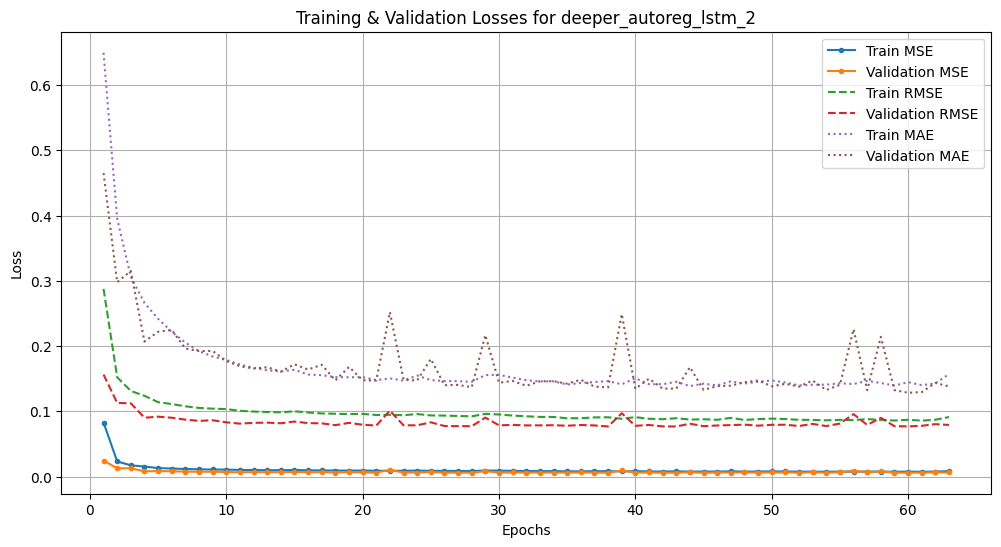

In [8]:
def plot_model_losses(model_data):
    model_name = model_data["config"]["name"]
    history = model_data["history"]
    epochs = range(1, len(history["val_mse"]) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history["train_mse"], label='Train MSE', marker='o', markersize=3)
    plt.plot(epochs, history["val_mse"], label='Validation MSE', marker='o', markersize=3)
    plt.plot(epochs, history["train_rmse"], label='Train RMSE', linestyle='--')
    plt.plot(epochs, history["val_rmse"], label='Validation RMSE', linestyle='--')
    plt.plot(epochs, history["train_mae"], label='Train MAE', linestyle=':')
    plt.plot(epochs, history["val_mae"], label='Validation MAE', linestyle=':')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training & Validation Losses for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage after finding best_model_data:
plot_model_losses(best_model_data)

In [23]:
#load data
batch_size = 512
scaler_filtered = joblib.load("scaler_filtered.save")
val_ds_filtered = load_val(filter_stationary=True, scaler=scaler_filtered)
scaler_unfiltered = joblib.load("scaler_unfiltered.save")
val_ds_unfiltered = load_val(filter_stationary=False, scaler=scaler_unfiltered)
val_loader_filtered = DataLoader(val_ds_filtered, batch_size=batch_size, num_workers=4, shuffle=False)
val_loader_unfiltered = DataLoader(val_ds_unfiltered, batch_size=batch_size, num_workers=4, shuffle=False)

Loading VAL...


100%|██████████| 12847/12847 [00:23<00:00, 541.72it/s]


Loading VAL...


100%|██████████| 12847/12847 [00:20<00:00, 624.26it/s]


In [24]:
best_model_path = "deeper_autoreg_lstm_2_best.pt"
full_best_model_path = os.path.join(base_path, best_model_path)

model = Seq2SeqLSTM(**best_model_data["config"]["model_kwargs"]).to(device)
model.load_state_dict(torch.load(full_best_model_path, map_location=device))
model.eval()

Seq2SeqLSTM(
  (encoder_lstm): LSTM(2, 512, num_layers=4, batch_first=True)
  (decoder_lstm): LSTM(2, 512, num_layers=4, batch_first=True)
  (l_out): Linear(in_features=512, out_features=2, bias=True)
)

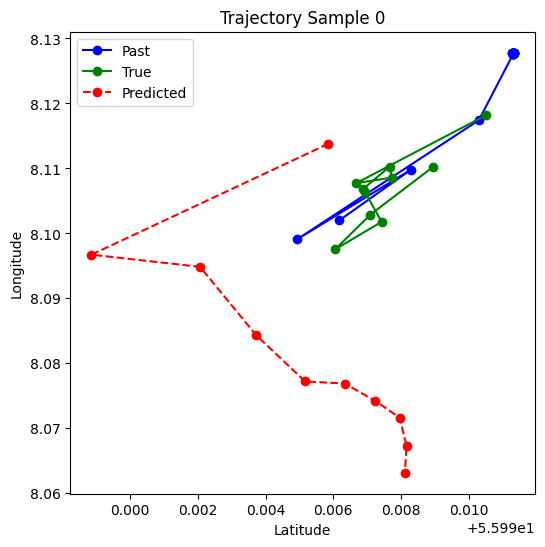

In [25]:
#plot a few samples from the validation set
num_samples_to_plot = 1

# plot
for idx, (x, y) in enumerate(val_loader_filtered):
    if idx >= num_samples_to_plot:
        break
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        y_pred = model(x)
    
    # pick the first element in the batch
    x_np = x[0].cpu().numpy()             # (30,5)
    y_np = y[0].cpu().numpy()             # (10,5)
    y_pred_np = y_pred[0].cpu().numpy().reshape(10, 2)  # reshape flat 50 -> (10,5)

    plot_paths(x_np, y_np, y_pred_np, idx, scaler=scaler_filtered)


In [26]:
# compute per-sample MSE on validation set (notice here we do per-sample MSE, so the total loss is 20 times smaller)
all_mse = []
all_samples = []

for x, y in tqdm(val_loader_filtered, desc="Computing per-sample MSE"):
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        y_pred = model(x)
    
    mse_per_sample = torch.mean((y_pred - y)**2, dim=[1,2])
    all_mse.append(mse_per_sample.cpu().numpy())
    
    for i in range(x.shape[0]):
        all_samples.append({
            "x": x[i].cpu().numpy(),
            "y": y[i].cpu().numpy(),
            "y_pred": y_pred[i].cpu().numpy()
        })

all_mse = np.concatenate(all_mse)
sorted_indices = np.argsort(all_mse)

n = len(all_mse)

Computing per-sample MSE: 100%|██████████| 868/868 [03:13<00:00,  4.48it/s]


In [27]:
percentiles = [10, 30, 50, 80, 90, 95, 99, 100]
print("\nMSE percentile summary:\n")
for p in percentiles:
    threshold = np.percentile(all_mse, p)
    print(f"{p:>3}% of samples have MSE ≤ {threshold:.6f}")


MSE percentile summary:

 10% of samples have MSE ≤ 0.000006
 30% of samples have MSE ≤ 0.000014
 50% of samples have MSE ≤ 0.000029
 80% of samples have MSE ≤ 0.000128
 90% of samples have MSE ≤ 0.000316
 95% of samples have MSE ≤ 0.000660
 99% of samples have MSE ≤ 0.002172
100% of samples have MSE ≤ 9.043043



Plotting 3 samples from Best group:


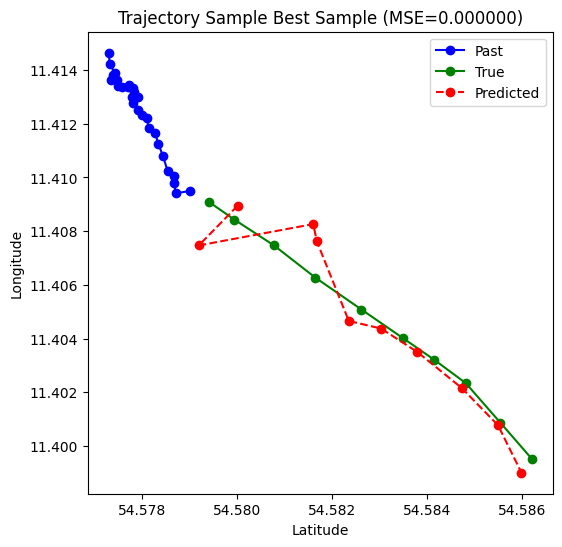

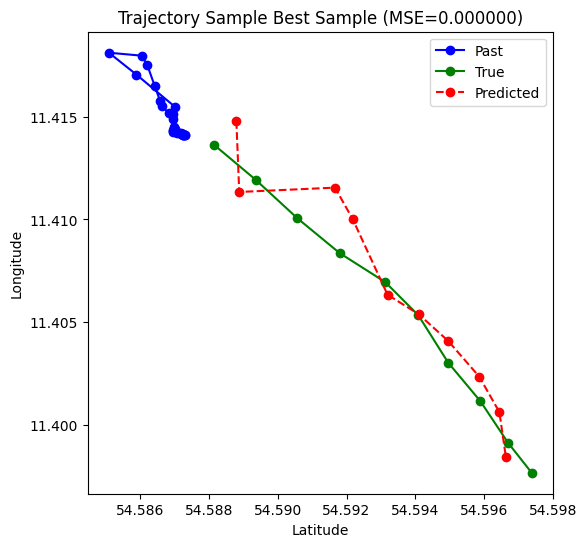

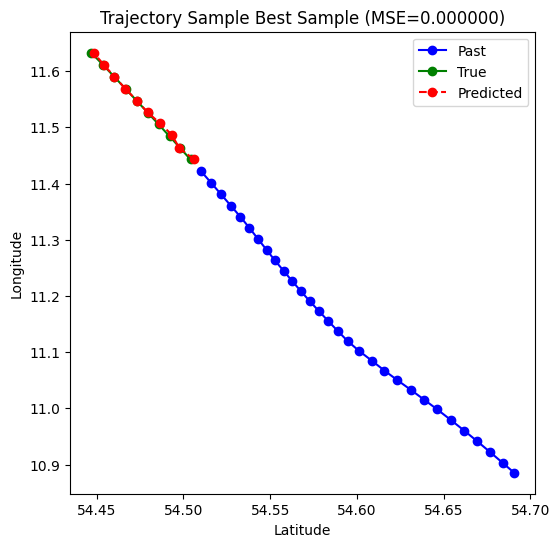


Plotting 3 samples from Q1 group:


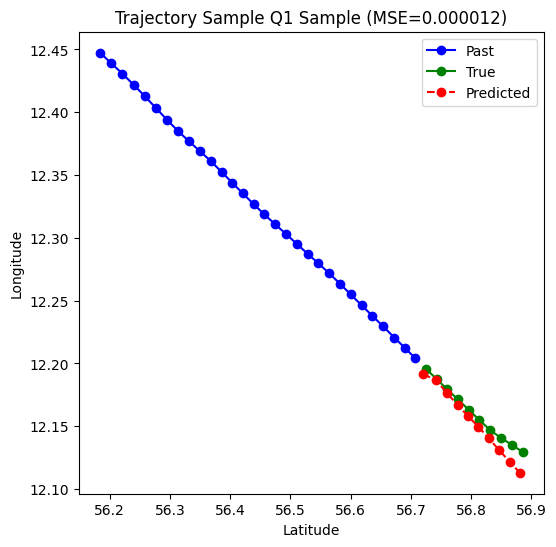

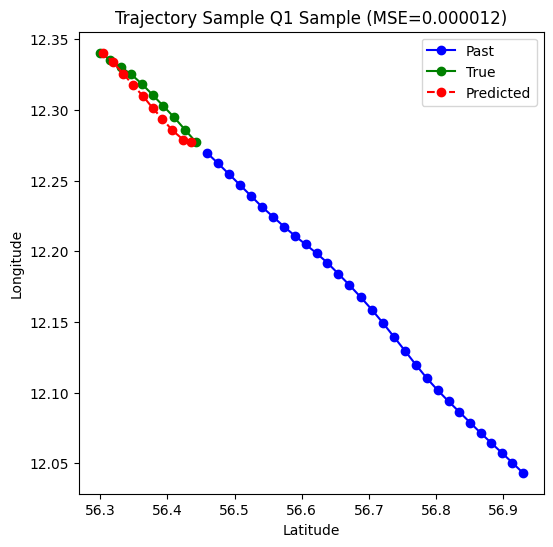

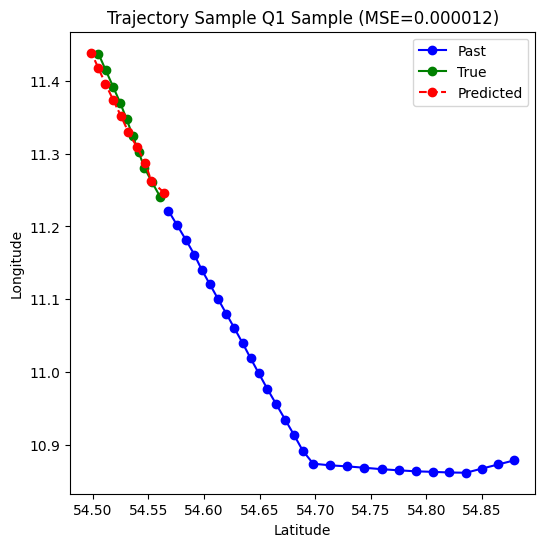


Plotting 3 samples from Median group:


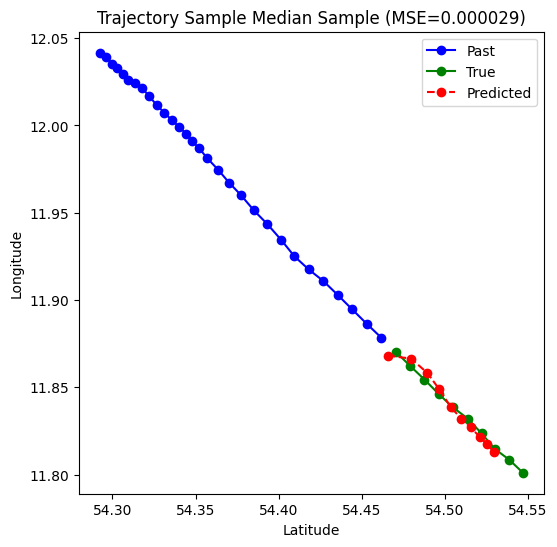

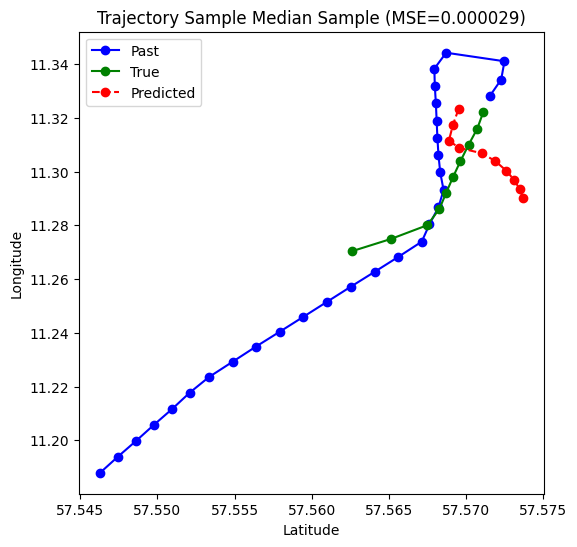

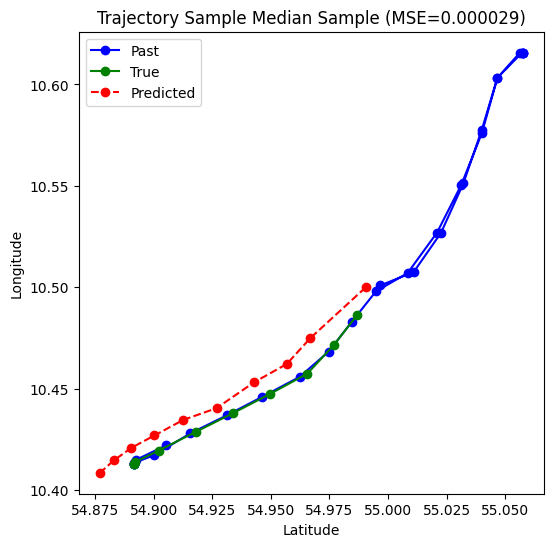


Plotting 3 samples from Q3 group:


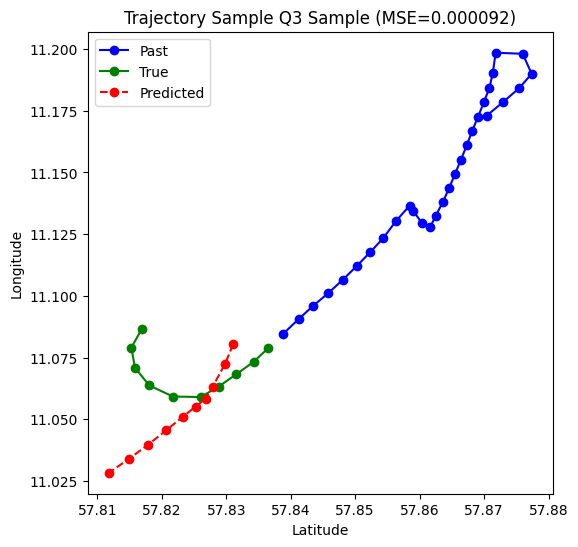

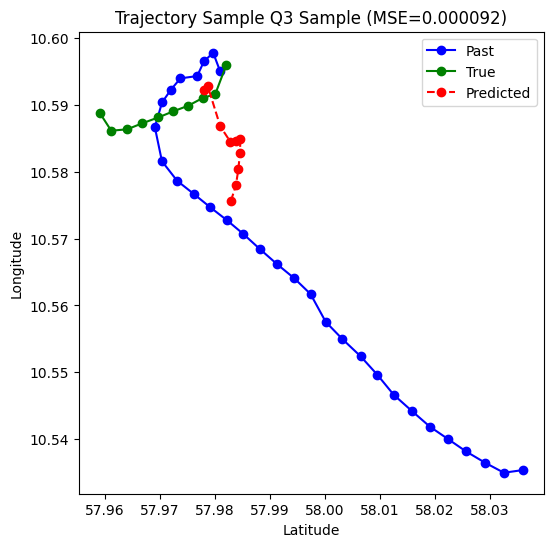

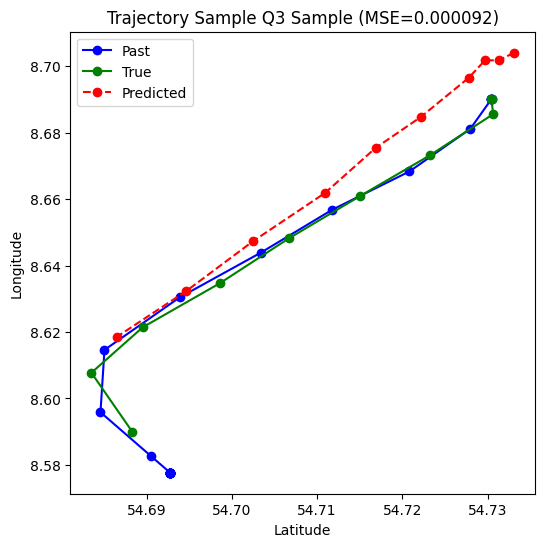


Plotting 3 samples from Worst group:


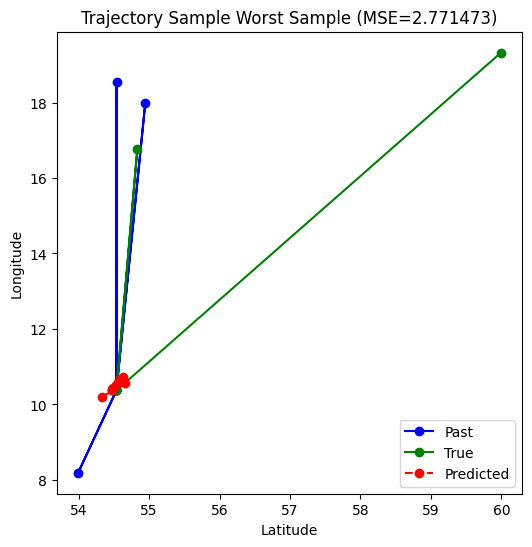

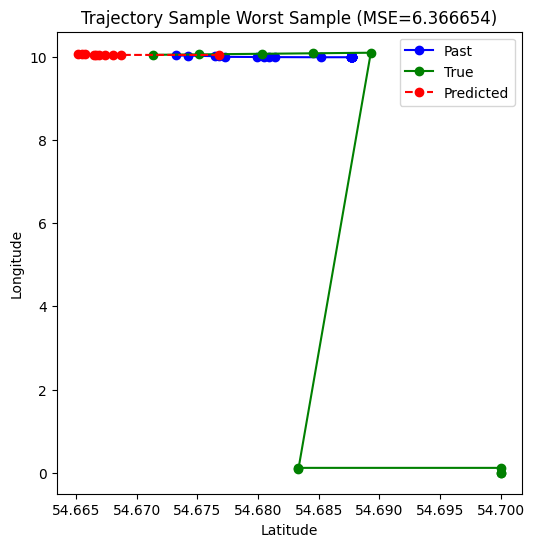

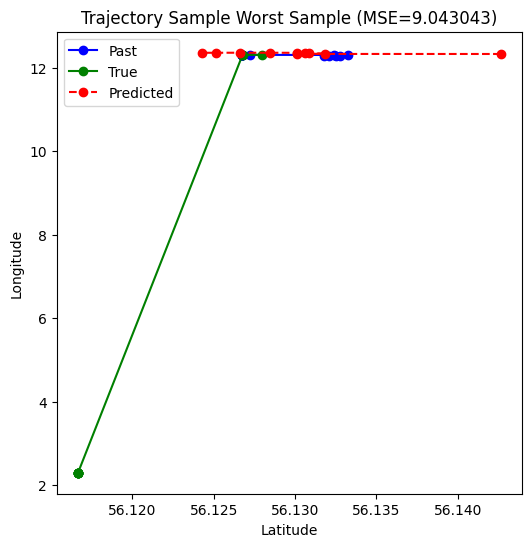

In [28]:
groups = {
    "Best": sorted_indices[:3],
    "Q1": sorted_indices[n//4:n//4+3],
    "Median": sorted_indices[n//2:n//2+3],
    "Q3": sorted_indices[3*n//4:3*n//4+3],
    "Worst": sorted_indices[-3:]
}

def plot_sample(sample, title):
    plot_paths(sample["x"], sample["y"], sample["y_pred"], title, scaler=scaler_filtered)

for group_name, indices in groups.items():
    print(f"\nPlotting 3 samples from {group_name} group:")
    for idx in indices:
        plot_sample(all_samples[idx], f"{group_name} Sample (MSE={all_mse[idx]:.6f})")

In [30]:
#Haversine formula to calculate from long lats to meters


def haversine_np(true_lonlat, pred_lonlat, radius_km=6371.0):
    """
    true_lonlat, pred_lonlat: Arrays of Form (T, 2) with [lon_deg, lat_deg] in degree.
    """
    # recalc long and lat to radiants
    lon_true = np.radians(true_lonlat[:, 0])
    lat_true = np.radians(true_lonlat[:, 1])
    lon_pred = np.radians(pred_lonlat[:, 0])
    lat_pred = np.radians(pred_lonlat[:, 1])

    dlon = lon_pred - lon_true 
    dlat = lat_pred - lat_true

    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat_true) * np.cos(lat_pred) * np.sin(dlon / 2.0) ** 2
    )
    c = 2.0 * np.arcsin(np.sqrt(a))
    distances_km = radius_km * c
    mean_distance_km = distances_km.mean()

    return distances_km, mean_distance_km

In [35]:
#First Batch Sample Haversine
num_samples = 1

for idx, (x, y) in enumerate(val_loader_filtered):
    if idx >= num_samples:
        break

    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        y_pred = model(x)

    # plot first samples from batch
    y_np      = y[0].cpu().numpy()                 # (10, 2) – scaled
    y_pred_np = y_pred[0].cpu().numpy().reshape(10, 2)  # (10, 2) – caled

    # --- inverse Scaling  ---
    y_true_unscaled = scaler_filtered.inverse_transform(y_np)      # (10, 2)
    y_pred_unscaled = scaler_filtered.inverse_transform(y_pred_np) # (10, 2)

    # here: column 0 = lon, column = lat
    true_lonlat = y_true_unscaled      # (10, 2)
    pred_lonlat = y_pred_unscaled      # (10, 2)

    # --- Haversine Calculation ---
    dists_km, mean_dist_km = haversine_np(true_lonlat, pred_lonlat)

    print(f"Sample {idx} – per-step Haversine [km]:")
    for i, d in enumerate(dists_km, start=1):
        print(f"  Step {i}: {d:.6f} km")
    print(f"Sample {idx} – mean Haversine over 10 steps [km]: {mean_dist_km:.4f}")



Sample 0 – per-step Haversine [km]:
  Step 1: 0.524437 km
  Step 2: 1.136263 km
  Step 3: 0.530838 km
  Step 4: 1.982688 km
  Step 5: 3.255209 km
  Step 6: 3.323734 km
  Step 7: 4.010424 km
  Step 8: 4.110590 km
  Step 9: 4.506035 km
  Step 10: 6.125741 km
Sample 0 – mean Haversine over 10 steps [km]: 2.9506


In [40]:
print("\n=== Haversine Distance Evaluation by Groups ===")

for group_name, indices in groups.items():
    group_means = []

    print(f"\n### {group_name} group ###")

    for idx in indices:
        sample = all_samples[idx]

        # inverse scale
        y_true_scaled = sample["y"]
        y_pred_scaled = sample["y_pred"]
        y_true_unscaled = scaler_filtered.inverse_transform(y_true_scaled)
        y_pred_unscaled = scaler_filtered.inverse_transform(y_pred_scaled)

        # Compute Haversine
        dists_km, mean_hav_km = haversine_np(y_true_unscaled, y_pred_unscaled)

        # Save group mean
        group_means.append(mean_hav_km)

        # --- Pretty step-wise print for groups ---
        print(f"\nSample {idx} (MSE={all_mse[idx]:.6f}) – Haversine per step:")
        for step, d in enumerate(dists_km, start=1):
            print(f"  Step {step:02d} → {d:10.6f} km")

        print(f"  → Mean Haversine for this sample: {mean_hav_km:.6f} km")




=== Haversine Distance Evaluation by Groups ===

### Best group ###

Sample 13580 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.068811 km
  Step 02 →   0.134585 km
  Step 03 →   0.126003 km
  Step 04 →   0.151349 km
  Step 05 →   0.055563 km
  Step 06 →   0.064737 km
  Step 07 →   0.050344 km
  Step 08 →   0.022891 km
  Step 09 →   0.011926 km
  Step 10 →   0.062605 km
  → Mean Haversine for this sample: 0.074881 km

Sample 62904 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.147275 km
  Step 02 →   0.084086 km
  Step 03 →   0.204412 km
  Step 04 →   0.189598 km
  Step 05 →   0.069135 km
  Step 06 →   0.006271 km
  Step 07 →   0.118385 km
  Step 08 →   0.133531 km
  Step 09 →   0.168344 km
  Step 10 →   0.119799 km
  → Mean Haversine for this sample: 0.124084 km

Sample 87022 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.209583 km
  Step 02 →   0.057383 km
  Step 03 →   0.328291 km
  Step 04 →   0.234567 km
  Step 05 →   0.022864 km
  Step 06 →   0.038345 km
  Step